# NOPT048: 2. Praktická domáca úloha
### Graf bez orientovaných cyklov (Minimum Feedback Arc Set Problem)
#### Róbert Eckhaus

Zadanie:

Na vstupu máte orientovaný graf s váhovou funkcí na hranách. Vaším úkolem je napsat IP, který
najde nejmenší váženou podmnožinu hran takovou, že po jejím odebrání graf nebude obsahovat
žádnou orientovanou kružnici. Graf na vstupu neobsahuje smyčky ani cykly délky 2.
V této úloze, na rozdíl od předešlé, nemá být výstupem vašeho programu zadání pro glpsol, ale
máte si glpsol volat sami. Díky tomu můžete při řešení této úlohy volat glpsol opakovaně, což
se vám pravděpodobně bude hodit.

## Rozbor problému

Zadaný problém je identický so známym problémom nájdenia tzv. Mimumum Feedback Arc (Edge) Set (ďalej len MFES). Ten je podrobne rozobraný v článku

[**Ali Baharev, Hermann Schichl, Arnold Neumaier: An exact method for the minimum feedback arc set problem**](http://www.mat.univie.ac.at/~herman/fwf-P27891-N32/minimum_feedback_arc_set.pdf)

v ktorom je aj popísaný postup, ktorý implementujeme. Obecne MFES je NP-complete a ťažko aproximovateľný problém. Postupným pridávaním omezujúcich podmienok a využitím heuristických aproximácií ho však vieme v niektorých prípadoch riešiť celkom efektívne.

## Pomalé optimálne riešenie

Majme na vstupe orientovaný graf $G = (E_G, V_G)$. Označme hľadaný MFES ako $F$ a množinu všetkých (jednoduchých) cyklov v $G$ ako $C = (c_1, c_2, \dots, c_l)$.

Jedno z optimálnych riešení je založné na jednoduchom pozorovaní: pre každý cyklus $c \in C$ musí existovať aspoň jeda hrana $e_c \in F$, ktorá na tomto cykle leží. Pre nájdenie MFES nám stačí nájsť hrany, ktoré túto podmienku spĺňajú a majú najnižšiu možnú váhu.

Nájdeme si teda všetky cykly v grafe (čo môže byť problematické, dokonca aj pre riedke grafy) a pre každý cyklus pridáme podmienku, že musí obsahovať aspoň jednu hranu z MFES. Potom už len minimalizujeme súčet váh vybraných vrcholov. Toto vieme formulovať ako nasledujúci lineárny program:

$$ \min_y\sum^m_{j=1}w_jy_j$$
$$ \sum^m_{j=1}{C_{i,j}y_j}\geq1\quad \forall i = 1..l$$
$$ y \in \{0,1\} $$

kde:
 - $y_e$ je $1$ ak hrana $e$ patrí MFES, inak 0
 - $w_e$ je váha hrany $e$
 - $C_{e,c}$ je matica cyklov: 1 ak hrana $e$ patrí do cyklu $c$, inak 0
 
## Hlúpa heuristika

Prehľadáme graf do hĺbky a nájdeme v ňom spätné hrany, tie tvoria určite nejaký feedback edge set (FES) - aj keď nie nutne najmenší. Týmto spôsobom vieme jednoducho a rýchlo získať prípustné riešenie problému. To sa nám neskôr zíde.
Bolo by možné použiť nejakú sofistikovanejšiu "heuristiku" (viacero je ich popísaných v spomínanom článku), to by viedlo k o niečo rýchlejšej konvergencii iteratívneho algoritmu k optimálnemu riešeniu.

## Iteratívny postup = Pomalé optimálne riešenie + Hlúpa heuristika

Hlavnou myšlienkou programu je začať s relatívne zlým prípustným riešením, ktoré vieme vypočítať rýchlo našou heuristikou. Na základe tohto riešenia budeme pridávať nové podmienky do lineárneho programu.

Budeme používať popísané pomalé optimálne riešenie MFES. Jeho hlaným problémom bol neúnosný počet cyklov. Začneme teda s prázdnou maticou cyklov. Vypočítame si heuristikou $F^{(0)}$ - prvý prípustný FES. Z prípustného riešenia zistíme, ktoré cykly by mohli byť relevantné pre ďalšie hľadanie. Budú to tie, ktoré obsahujú hrany z $F^{(0)}$. Nájdeme teda v $G$ pre každú hranu z $F^{(0)}$ najkratší (najľahší) orientovaný cyklus, ktorý túto hranu obsahuje a ten pridáme do matice cyklov.

Takto rozšírime maticu cyklov (z prázdnej matice) podľa grafu $G$ a prípustného riešenia $F_0$. Teraz už máme maticu cyklov, ktorú môžeme použiť v exaktnom lineárnom programe, ktorý počíta MFES. Takto vypočítaná množina - označme $S$ - však ešte nemusí byť optimálny MFES grafu $G$, keďže neobsahuje informácie o všetkých cykloch - poslúži len ako základ pre výpočet lepšieho feedback edge set-u. Ak je však graf $G$ po odobraní hrán z $S$ acyklický, máme optimálne riešenie (keďže sme našli množinu, po ktorej odobraní je graf acyklický a pridaním ďalších podmienok by sa jej váha mohla len zväčšiť)

Každá iterácia algoritmu prebieha nasledovne:

- na začiatku $i$-tej iterácie máme k dispozícii maticu cyklov $C^{(i)}$
- vypočítame lineárnym programom nové prípustné riešenie problému na základe aktuálnej matice cyklov  $C^{(i)}$. Výlednú množinu hrán označme $S$
- ako $G^{(i)}$ označíme graf, ktorý vznikne z $G$ po odobraní všetkých hrán z $S$
- ak je $G^{(i)}$ acyklický skončili sme, $S$ je riešenie
- ak nie, vypočítame ďalšie prípustné riešenie $F^{(i)}$ v grafe $G^{(i)}$ pomocou heuristiky
- rozšírime maticu cyklov tak, aby obsahovala pre každú hranu z $F^{(i)}$ najkratší cyklus v $G^{(i)}$, ktorý ju obsahuje (ak taký existuje)

## Zdrojový kód

Program v Python-e je stiahnuteľný z [eckhaus.github.io/mfes/mfes.py](http://eckhaus.github.io/mfes/mfes.py). Ako jediný argument očakáva názov súboru s dátami. Výstup odpovedá funkcii *solve* uvedenej nižšie (bez atribútov).
Tento jupyter notebook je dostupný na [eckhaus.github.io/mfes/mfes.ipynb](http://eckhaus.github.io/mfes/mfes.ipynb)

## Implementácia

Používame knižnice NetworkX (na grafové operácie), NumPy, Matplotlib (zobrazovanie grafov pre lepší debugging) a re (na načítanie vstupu)

In [1]:
import re
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import subprocess
%matplotlib inline

### Inicializácia
Načítame vstup zo súboru, naparsujeme regexpom a vytvoríme orientovaný graf G.

In [2]:
def getGraph (fileName):
    f = open(fileName, 'r')
    f.readline()
    G=nx.DiGraph()
    id = 0
    for line in f:
        id += 1
        m = re.match(r"( *[0-9]+) --> ( *[0-9]+) \( *([0-9]+)\)", line)
        G.add_edge(m.group(1), m.group(2), {'weight': m.group(3), 'id' : id})

    f.close()
    return G

**computeHeuristicTree (G)** Graf prehľadáme do hĺbky, vypočítame si stromové hrany a tie označíme ako výsledok (takže doplnok výsledku v grafe $G$ je hľadaný FES)

In [3]:
def computeHeuristicTree(G):
    T = nx.DiGraph()
    for e in nx.dfs_edges(G):
        T.add_edge(e[0], e[1], weight = G[e[0]][e[1]]['weight'])
    return T

### Matica cyklov
** def computeCycleMatrix(G, F, C, cycleString, original) ** 
pridá nové cykly do matice cyklov $C$ na základe doplnku prípustného riešenia MFES *F* v grafe *G*, original je pôvodný graf na vstupe. 

postup výpočtu: pre každú hranu $(e_0, e_1)$ v prípustnom riešení (G\F) si nájdeme najkratší cyklus v G, ktorý ju obsahuje. To urobíme tak, že si vypočítame najkratšiu cestu z $e_1$ do $e_0$ a pridáme hranu $(e_0, e_1)$. Tento cyklus pridáme do matice cyklov ak v nej ešte nie je. Unikátnosť zaručíme tým, že pre každý cyklus si pamätáme lexikograficky najmenšie usporiadanie.

Vracia maticu cyklov a zoznam cyklov spracovaný v formáte vhodnom pre mathprog.

In [4]:
#  graph G, complement of feedback set F, cycle matrix C so far, cycle string(to IP), task graph
def computeCycleMatrix(G, F, C, cycleString, original):
    # did we append any string to cycle matrix?
    appending = False
    # for all edges in feasable solution
    for e in set(G.edges()) - set(F.edges()):
        try:
            # compute shortest cycle if it exists
            row = nx.shortest_path(G, e[1], e[0])            
        except:
            continue
        # "normalize" the cycle - use the least lex. order permutation
        perm_anchor = np.argmin(row)
        row_normal = row[perm_anchor:] + row[:perm_anchor]
        # if this cycles is not in the matrix
        if (row_normal) not in C:
            # delete semicolon when appending to cycle string
            if (appending == False) and (cycleString!=""):
                cycleString = cycleString[:-1] + ",\n"
            appending = True
            # add new constraints to exact LP
            for vertex in range(len(row_normal)-1):
                cycleString += str(original[row_normal[vertex]][row_normal[vertex+1]]['id']) 
                cycleString += " " + str(len(C) + 1) + " 1,\n"                
            cycleString += str(original[row_normal[-1]][row_normal[0]]['id']) + " " + str(len(C) +1) +" 1,\n"
            C.append(row_normal)

    if appending:
        cycleString = cycleString[:-2] + ";"
    return (C, cycleString)

**computeWeightString(G)** vráti zoznam hrán pre lineárny program v mathprogu

In [5]:
def computeWeightString(G):
    weightString = ""
    for e in G.edges():
        weightString += str(G[e[0]][e[1]]['id']) + " " + str(G[e[0]][e[1]]['weight']) + ",\n"
    return weightString[:-2] + ";"

### Lineárny program

**def WriteLP (fileName, m, l, cycles, weights)** vygeneruje lineárny program popísaný v sekcii "pomalé optimálne riešenie" za vstup berie počet hrán grafu, počet cyklov, pracovanú maticu cyklov (z *computeCycleMatrix*) a zoznam váh hrán z *computeWeightString* a zapíše ho do súboru *fileName*


In [6]:
def WriteLP (fileName, m, l, cycles, weights):
    lp = '''/* edges */
    param m, integer, >= 0;
    set E, default 1..m;

    /* loops */
    param l, integer, >=0;
    set L, default 1..l;

    /* edge weights */
    param w{e in E}, integer, default 0;

    /* cycle matrix */
    param a{(i,j) in (E cross L)}, binary, default 0;

    /* is this edge in FES */
    var y{i in E}, binary;

    minimize obj: sum{e in E} w[e]*y[e];
    s.t. c{i in L}: sum{e in E}(a[e,i]*y[e]) >= 1;

    solve;


    printf "OUTPUT\\n";
    printf{e in E: y[e]==1}: "%13s\\n", e;
    printf "OUTPUT\\n";

    data;

    param m := ''' + str(m) + ''';
    param l := ''' + str(l) + ''';

    /* edge e in loop l is 1 */
    param : a := 
    ''' + cycles + '''

    /* edge e has weight w*/
    param : w :=
    ''' + weights + ''' 
    end;

    '''
    f = open(fileName, 'w')
    f.write(lp)
    f.close()

**solveOptimal(G)** vráti riešenie optimálneho lineárneho programu (ako orientovaný graf)

In [7]:
def solveOptimal(G, draw=False):
    # run glpsol from command line
    outp = subprocess.check_output(["glpsol", "--math", "out_lin"]).split('\n')
    
    # extract text between OUTPUT "tags"
    isOut = False
    out_edges = []
    for line in outp:
        if line == "OUTPUT": isOut = not isOut
        if isOut:
            out_edges.append(line)     
    parsed_edges = set(map(int, out_edges[1:]))
    
    # construct the output
    newFeedback = nx.DiGraph()
    for e in G.edges():
        if G[e[0]][e[1]]['id'] in parsed_edges:
            newFeedback.add_edge(e[0], e[1], {'weight': G[e[0]][e[1]]['weight'], 'id' : G[e[0]][e[1]]['id']})
    
    # draw the graph
    if draw:
        edge_color_list = ['black' if e in set(newFeedback.edges()) else 'red' for e in G.edges()]
        nx.draw(G, pos=nx.spring_layout(G), node_size=300, edge_color=edge_color_list, with_labels = True)
        plt.show()

    return newFeedback

**difference (X, Y)** odoberie hrany grafu Y z grafu X

In [8]:
def difference (X, Y): #X\Y
    rslt = nx.DiGraph()
    for e in X.edges_iter():
        if not Y.has_edge(e[0],e[1]):
            rslt.add_edge(e[0],e[1],{'weight': X[e[0]][e[1]]['weight'], 'id' : X[e[0]][e[1]]['id']})
    return rslt

# get weight of a graph
def getWeight(X):
    totW = 0
    for e in X.edges_iter(): 
        totW += int(X[e[0]][e[1]]['weight'])
    return totW

## Samotný program

In [9]:
def solve(data, edges = True, draw = False, verbose = False):

    # initialize
    G = getGraph(data)
    G_i = G.copy()
    C, cycleString = [], ""

    # compute the first feasible solution
    F_i  = computeHeuristicTree(G)
    C, cycleString = computeCycleMatrix(G_i, F_i, C, cycleString, G)
    weightString = computeWeightString(G)
    WriteLP('out_lin', len(G.edges()), len(C), cycleString, weightString)

    iter = 1
    while (True):
        #solve relaxed problem .. output S: feedback set
        S = solveOptimal(G, draw)
        G_i = difference(G, S)     
        if verbose:
            print "Iterácia: ", iter    
            print "Váha: ", getWeight(S)
            print "Veľkosť matice cyklov: ",len(C)

        #test if we are done
        if nx.is_directed_acyclic_graph(G_i):
            if verbose:
                print "OPTIMUM !!!\n"
            
            print "#OUTPUT: " + str(getWeight(S))
            if edges:
                for e in S.edges_iter():
                    print str(int(e[0])) + " --> " + str(int(e[1]))
                print "#OUTPUT END"
            break

        #Compute new feedback set of G_i using heuristic   
        F_i = computeHeuristicTree(G_i)

        # extend cycle matrix
        C, cycleString = computeCycleMatrix(G_i, F_i, C, cycleString,G) 

        # write new LP
        WriteLP('out_lin', len(G.edges()), len(C), cycleString, weightString)


        iter += 1

### Pár príkladov

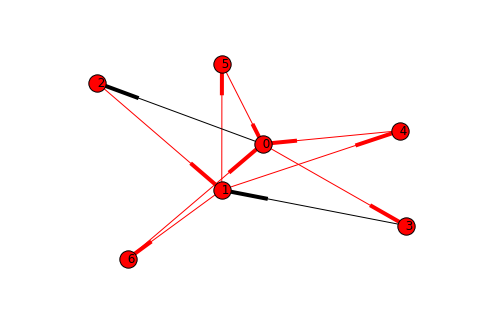

Iterácia:  1
Váha:  2
Veľkosť matice cyklov:  4
OPTIMUM !!!

#OUTPUT: 2
3 --> 1
0 --> 2
#OUTPUT END


In [10]:
solve('vstupy/vstup-s0.txt', draw = True, verbose=True)

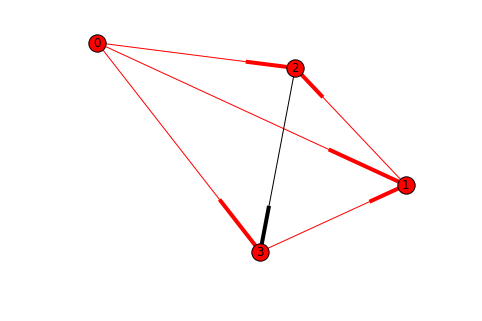

#OUTPUT: 2
2 --> 3
#OUTPUT END


In [11]:
solve('vzorovy_vstup', draw = True)

In [12]:
for x in range (9): solve ('vstupy/vstup-s'+str(x)+'.txt', edges = False)
for x in range (1,9): solve ('vstupy/vstup-00'+str(x)+'.txt', edges = False)

#OUTPUT: 2
#OUTPUT: 2
#OUTPUT: 2
#OUTPUT: 2
#OUTPUT: 2
#OUTPUT: 2
#OUTPUT: 2
#OUTPUT: 2
#OUTPUT: 2
#OUTPUT: 753
#OUTPUT: 773
#OUTPUT: 690
#OUTPUT: 708
#OUTPUT: 798
#OUTPUT: 728
#OUTPUT: 684
#OUTPUT: 734
